In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,64) #input num:2 for x,t
        self.hidden_layer2 = nn.Linear(64,64)
        self.hidden_layer3 = nn.Linear(64,64)
        self.hidden_layer4 = nn.Linear(64,64)
        self.hidden_layer5 = nn.Linear(64,64)
        self.output_layer = nn.Linear(64,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())
#optimizer = torch.optim.LBFGS(net.parameters())


In [ ]:
def f(x,t, net):
    u = net(x,t)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_xx - u_t
    #pde = u_t - 0.01*u_xx-2*u*(1-u)
    #pde = u_x - 2*u_t - u #Exact solution's error(should be 0)
    return pde


In [ ]:
x_bc = np.random.uniform(low=-1.0, high=1.0, size=(500,1))
t_bc = np.zeros((500,1))
u_bc = np.ones((500,1))
#u_bc = 0.5*(np.sin(np.pi*x_bc))**2
#u_bc = 6*np.exp(-3*x_bc) #BC when t=0


In [ ]:
x2_bc = np.ones((500,1))*(-1)
x3_bc = np.ones((500,1))*1
t2_bc = np.random.uniform(low=0.0, high=1.0, size=(500,1))
u2_bc = np.zeros((500,1))



In [ ]:
iterations = 20000
previous_validation_loss = 99999999.0
loss_count=[]
for epoch in range(iterations):
    optimizer.zero_grad()

    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)

    net_bc_out = net(pt_x_bc, pt_t_bc)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)

    pt_x2_bc = Variable(torch.from_numpy(x2_bc).float(), requires_grad=False).to(device)
    pt_t2_bc = Variable(torch.from_numpy(t2_bc).float(), requires_grad=False).to(device)
    pt_u2_bc = Variable(torch.from_numpy(u2_bc).float(), requires_grad=False).to(device)

    net_bc_out2 = net(pt_x2_bc, pt_t2_bc)
    mse_u2 = mse_cost_function(net_bc_out2, pt_u2_bc)

    pt_x3_bc = Variable(torch.from_numpy(x3_bc).float(), requires_grad=False).to(device)
    pt_t3_bc = Variable(torch.from_numpy(t2_bc).float(), requires_grad=False).to(device)
    pt_u3_bc = Variable(torch.from_numpy(u2_bc).float(), requires_grad=False).to(device)

    net_bc_out3 = net(pt_x3_bc, pt_t3_bc)
    mse_u3 = mse_cost_function(net_bc_out3, pt_u3_bc)

    x_collocation = np.random.uniform(low=-1.0, high=1.0, size=(500,1)) #Fixed range
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1)) #Fixed range
    all_zeros = np.zeros((500,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

    f_out = f(pt_x_collocation, pt_t_collocation, net)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    loss = mse_u + mse_u2 + mse_u3 + mse_f

    loss.backward()


    optimizer.step()

    with torch.autograd.no_grad():
        loss_count.append(loss.item())
        if epoch % 1000 == 0:
    	    print(epoch,"Traning Loss:",loss.item())


0 Traning Loss: 0.6793434023857117
1000 Traning Loss: 0.1367509663105011
2000 Traning Loss: 0.11377733945846558
3000 Traning Loss: 0.09673239290714264
4000 Traning Loss: 0.08961513638496399
5000 Traning Loss: 0.08565407991409302
6000 Traning Loss: 0.0802554190158844
7000 Traning Loss: 0.07447027415037155
8000 Traning Loss: 0.06700088083744049
9000 Traning Loss: 0.06519021093845367
10000 Traning Loss: 0.05405570939183235
11000 Traning Loss: 0.0505838505923748
12000 Traning Loss: 0.0454435758292675
13000 Traning Loss: 0.037731707096099854
14000 Traning Loss: 0.025108877569437027
15000 Traning Loss: 0.019805219024419785
16000 Traning Loss: 0.01641678251326084
17000 Traning Loss: 0.013869991526007652
18000 Traning Loss: 0.01277799904346466
19000 Traning Loss: 0.012037539854645729


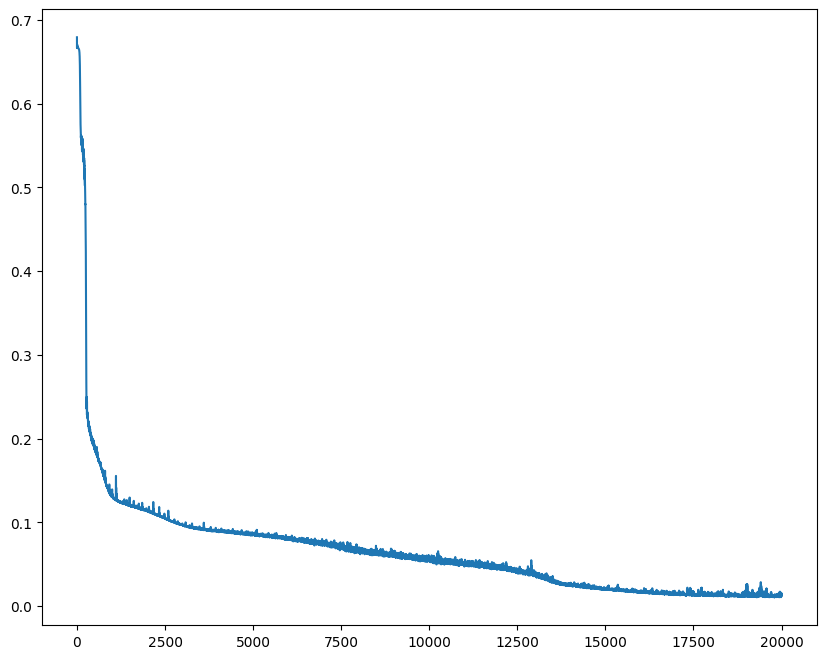

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(loss_count)
plt.show()

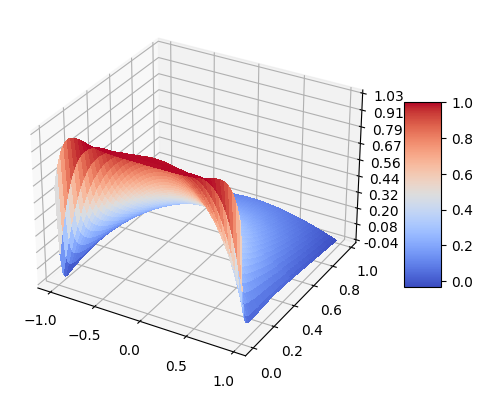

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Use add_subplot to create a 3D axes

x=np.arange(-1,1,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)



ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
print(ms_x)
print(ms_t)

[[-1.   -0.98 -0.96 ...  0.94  0.96  0.98]
 [-1.   -0.98 -0.96 ...  0.94  0.96  0.98]
 [-1.   -0.98 -0.96 ...  0.94  0.96  0.98]
 ...
 [-1.   -0.98 -0.96 ...  0.94  0.96  0.98]
 [-1.   -0.98 -0.96 ...  0.94  0.96  0.98]
 [-1.   -0.98 -0.96 ...  0.94  0.96  0.98]]
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.04 0.04 0.04 ... 0.04 0.04 0.04]
 ...
 [0.94 0.94 0.94 ... 0.94 0.94 0.94]
 [0.96 0.96 0.96 ... 0.96 0.96 0.96]
 [0.98 0.98 0.98 ... 0.98 0.98 0.98]]


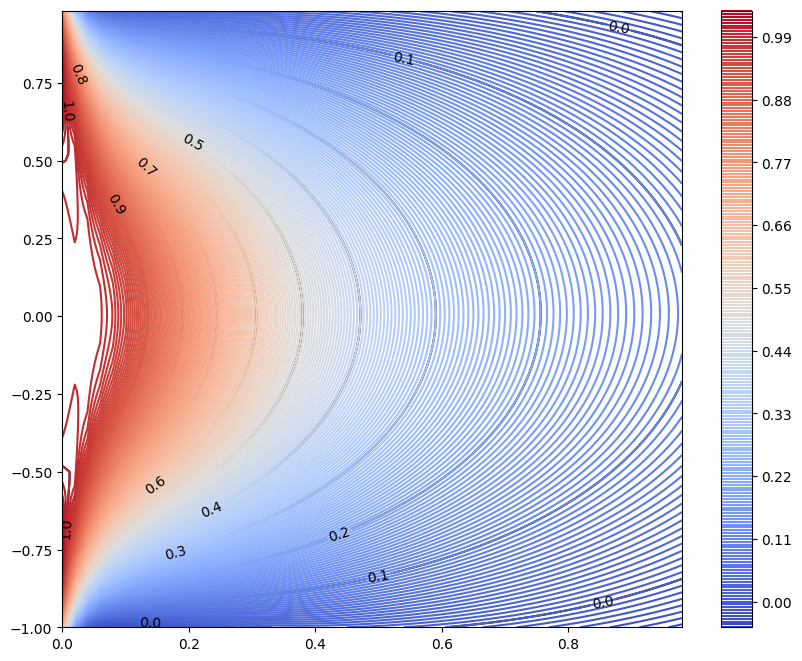

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

con1 = ax.contour(ms_t,ms_x,ms_u,levels=10 , colors='k')
con2 = ax.contour(ms_t,ms_x,ms_u,levels = 256, cmap='coolwarm')

ax.clabel(con1, inline=1, fontsize=10)
fig.colorbar(con2)
plt.show()